# GMM (Gaussian Mixture Model)
- ### Expectation-Maximization Algorithm
- ### maximum likelihood estimation

## Import library

In [1]:
import sys # 引数の操作
import csv # csvの読み込み
import numpy as np # 数値計算
import matplotlib.pyplot as plt # 可視化
from collections import Counter # 頻度カウント
from scipy.stats import multivariate_normal # 多次元ガウス分布の確率密度関数の計算
from mpl_toolkits.mplot3d import Axes3D # 可視化

## Prepare data
- #### data from 4 gaussian models

In [2]:
# 各クラスターに属するデータ数
# 今回は全てのクラスタでデータ数が同じと仮定する
# 全体のデータ数は N = N1 + N2 + N3 + N4 となる
# 各クラスタのデータ数
N1 = 4000
N2 = 3000
N3 = 2000
N4 = 1000

# 平均
Mu1 = [5, -5, -5]
Mu2 = [-5, 5, 5]
Mu3 = [-5, -5, -5]
Mu4 = [5, 5, 5]

# 共分散
Sigma1 = [[1, 0, -0.25], [0, 1, 0], [-0.25, 0, 1]]
Sigma2 = [[1, 0, 0], [0, 1, -0.25], [0, -0.25, 1]]
Sigma3 = [[1, 0.25, 0], [0.25, 1, 0], [0, 0, 1]]
Sigma4 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# 乱数を生成
X1 = np.random.multivariate_normal(Mu1, Sigma1, N1)
X2 = np.random.multivariate_normal(Mu2, Sigma2, N2)
X3 = np.random.multivariate_normal(Mu3, Sigma3, N3)
X4 = np.random.multivariate_normal(Mu4, Sigma4, N4)

### Plot data

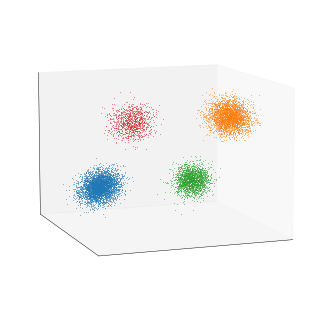

In [18]:
#plot data
# 描画準備
fig = plt.figure(figsize=(10, 10), dpi=40)
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

# 当サイトのカスタムカラーリスト
cm = plt.get_cmap("tab10")   

# メモリを除去
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# 少し回転させて見やすくする
ax.view_init(elev=10, azim=70)

# 描画
ax.plot(X1[:,0], X1[:,1], X1[:,2], "o", ms=0.5, color=cm(0))
ax.plot(X2[:,0], X2[:,1], X2[:,2], "o", ms=0.5, color=cm(1))
ax.plot(X3[:,0], X3[:,1], X3[:,2], "o", ms=0.5, color=cm(2))
ax.plot(X4[:,0], X4[:,1], X4[:,2], "o", ms=0.5, color=cm(3))

plt.show()

### Merge data from 4 groups

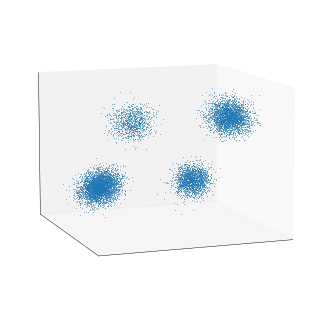

In [19]:
# 4つのクラスを結合
X = np.concatenate([X1, X2, X3, X4])

# 描画準備
fig = plt.figure(figsize=(10, 10), dpi=40)
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

# メモリを除去
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# 少し回転させて見やすくする
ax.view_init(elev=10, azim=70)

# 描画
ax.plot(X[:,0], X[:,1], X[:,2], "o", ms=0.5, color=cm(0))
plt.show()

# csvでデータを保存
np.savetxt("data.csv", X, delimiter=",")

## Load data

In [20]:
# ご自身の環境におけるcsvへのパス
csv_dir = r"C:\Users\kawaw\python\GMM_EMalgorithm\data.csv"

# csvを読み取って(N, D)行列を生成
with open(csv_dir) as f:
    reader = csv.reader(f)
    X = [_ for _ in reader]
    for i in range(len(X)):
      for j in range(len(X[i])):
        X[i][j] = float(X[i][j])

# 後のためにnumpy化しておく
X = np.array(X)

## Class Definition :
- ### Gaussian Mixture Model - Expectation Maximization algorithm

In [23]:
class GMMEM():
    def __init__(self, K):
        """コンストラクタ

        Args:
            K (int): クラスタ数

        Returns:
            None.

        Note:
            eps (float): オーバーフローとアンダーフローを防ぐための微小量
        """
        self.K = K
        self.eps = np.spacing(1)
    
    def init_params(self, X):
        """パラメータ初期化メソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ

        Returns:
            None.
        """
        # 入力データ X のサイズは (N, D)
        self.N, self.D = X.shape
        # 平均は標準ガウス分布から生成
        self.mu = np.random.randn(self.K, self.D)
        # 分散共分散行列は単位行列
        self.sigma = np.tile(np.eye(self.D), (self.K, 1, 1))
        # 重みは一様分布から生成
        self.pi = np.ones(self.K) / self.K
        # 負担率は標準正規分布から生成するがEステップですぐ更新するので初期値自体には意味がない
        self.r = np.random.randn(self.N, self.K)
    
    def gmm_pdf(self, X):
        """N個のD次元データに対してGMMの確率密度関数を計算するメソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ

        Returns:
            gmm_pdf (numpy ndarray): 各クラスタにおけるN個のデータに関して計算するため出力サイズは (N, K) となる
        """
        return np.array([self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.sigma[k]) for k in range(self.K)]).T # (N, K)

    def e_step(self, X):
        """Eステップを実行するメソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ

        Returns:
            None.

        Note:
            以下のフィールドが更新される
                self.r (numpy ndarray): (N, K)サイズの負担率
        """
        # GMMの確率密度関数を計算
        gmm_pdf = self.gmm_pdf(X)
        # 対数領域で負担率を計算 -> prevent overflow
        log_r = np.log(gmm_pdf) - np.log(np.sum(gmm_pdf, 1, keepdims=True) + self.eps)
        # 対数領域から元に戻す
        r = np.exp(log_r)
        # np.expでオーバーフローを起こしている可能性があるためnanを置換しておく
        r[np.isnan(r)] = 1.0 / (self.K)
        # 更新
        self.r = r
    
    def m_step(self, X):
        """Mステップを実行するメソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ

        Returns:
            None.

        Note:
            以下のフィールドが更新される
                self.pi (numpy ndarray): (K) サイズの混合率
                self.mu (numpy ndarray): (K, D) サイズの混合ガウス分布の平均
                self.sigma (numpy ndarray): (K, D, D) サイズの混合ガウス分布の分散共分散行列                
        """
        # Q関数を最大にするパラメータ (mu, sigma, pi) を計算する
        # まずは N_k を計算しておく
        N_k = np.sum(self.r, 0) # (K)
        # 最適なpiを計算して更新する
        self.pi = N_k / self.N # (K)
        # 最適なmuを計算して更新する
        self.mu = (self.r.T @ X) / (N_k[:, None] + np.spacing(1)) # (K, D)
        # 最適なsigmaを計算して更新する
        r_tile = np.tile(self.r[:,:,None], (1, 1, self.D)).transpose(1, 2, 0) # (K, D, N)
        res_error = np.tile(X[:,:,None], (1, 1, self.K)).transpose(2, 1, 0) - np.tile(self.mu[:,:,None], (1, 1, self.N)) # (K, D, N)
        self.sigma = ((r_tile * res_error) @ res_error.transpose(0, 2, 1)) / (N_k[:,None,None] + np.spacing(1)) # (K, D, D)
        
        #cf
        #*(Hadamard Product) np.ndarrayy(i,j)*np.ndarray(i,j)=np.ndarray(i,j)
        #@(normal matrix dot) ~ np.matmul()
        #in ndarray elements in other than left 2 axis is considered batch size
        #like (b,i,j) -> b=batch size and matrix size is (i,j)
    
    def visualize(self, X):
        """可視化を実行するメソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ

        Returns:
            None.
        
        Note:
            このメソッドでは plt.show が実行されるが plt.close() は実行されない
        """
        # クラスタリングを実行
        labels = np.argmax(self.r, 1) # (N)
        # 利用するカラーを極力揃えるためクラスタを出現頻度の降順に並び替える
        label_frequency_desc = [l[0] for l in Counter(labels).most_common()] # (K)
        # tab10 カラーマップを利用
        cm = plt.get_cmap("tab10")   
        # 描画準備
        fig = plt.figure(figsize=(8, 8), dpi=30)
        ax = fig.add_subplot(111, projection='3d')
        # メモリを除去
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        # 少し回転させて見やすくする
        ax.view_init(elev=10, azim=70)
        # 各クラスタごとに可視化を実行する
        for k in range(len(label_frequency_desc)):
            cluster_indexes = np.where(labels==label_frequency_desc[k])[0]
            ax.plot(X[cluster_indexes, 0], X[cluster_indexes, 1], X[cluster_indexes, 2], "o", ms=0.5, color=cm(k))
        plt.show()
    
    def execute(self, X, iter_max, thr):
        """EMアルゴリズムを実行するメソッド

        Args:
            X (numpy ndarray): (N, D)サイズの入力データ
            iter_max (int): 最大更新回数
            thr (float): 更新停止の閾値 (対数尤度の増加幅)

        Returns:
            None.
        """
        # パラメータ初期化
        self.init_params(X)
        # 各イテレーションの対数尤度を記録するためのリスト
        log_likelihood_list = []
        # 対数尤度の初期値を計算
        log_likelihood_list.append(np.mean(np.log(np.sum(self.gmm_pdf(X), 1) + self.eps)))
        # 更新開始
        for i in range(iter_max):
            # Eステップの実行
            self.e_step(X)
            # Mステップの実行
            self.m_step(X)
            # 今回のイテレーションの対数尤度を記録する
            log_likelihood_list.append(np.mean(np.log(np.sum(self.gmm_pdf(X), 1) + self.eps)))
            # 前回の対数尤度からの増加幅を出力する
            print("Log-likelihood gap: " + str(round(np.abs(log_likelihood_list[i] - log_likelihood_list[i+1]), 2)))
            # もし収束条件を満たした場合，もしくは最大更新回数に到達した場合は更新停止して可視化を行う
            if (np.abs(log_likelihood_list[i] - log_likelihood_list[i+1]) < thr) or (i == iter_max - 1):
                print(f"EM algorithm has stopped after {i + 1} iteraions.")
                self.visualize(X)
                break


## Execution

Log-likelihood gap: 25.0
Log-likelihood gap: 1.09
Log-likelihood gap: 0.0
Log-likelihood gap: 0.0
EM algorithm has stopped after 4 iteraions.


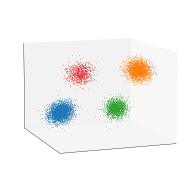

In [24]:
# モデルをインスタンス化する
model = GMMEM(K=4)
# EMアルゴリズムを実行する
model.execute(X, iter_max=100, thr=0.001)

Log-likelihood gap: 25.33
Log-likelihood gap: 1.29
Log-likelihood gap: 0.07
Log-likelihood gap: 0.0
Log-likelihood gap: 0.0
EM algorithm has stopped after 5 iteraions.


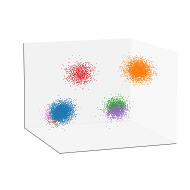

In [25]:
# モデルをインスタンス化する
model = GMMEM(K=8)
# EMアルゴリズムを実行する
model.execute(X, iter_max=100, thr=0.001)